This document is mostly cited from tutorial from https://github.com/WilliamCCHuang/GraphLIME (as I donot want to talk further about GraphLIME...), with edition for the init.py file and adding explanations with LIME on graph-structured data.

## 1. Import Libraries

In [1]:
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from graphlime import GraphLIME
from lime import lime_tabular

import matplotlib.pyplot as plt

%matplotlib inline

## 2. Prepare Cora dataset

### 2.1 Load dataset

In [2]:
dataset = Planetoid('.', 'Cora', transform=NormalizeFeatures())
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

### 2.2 Visualize the graph

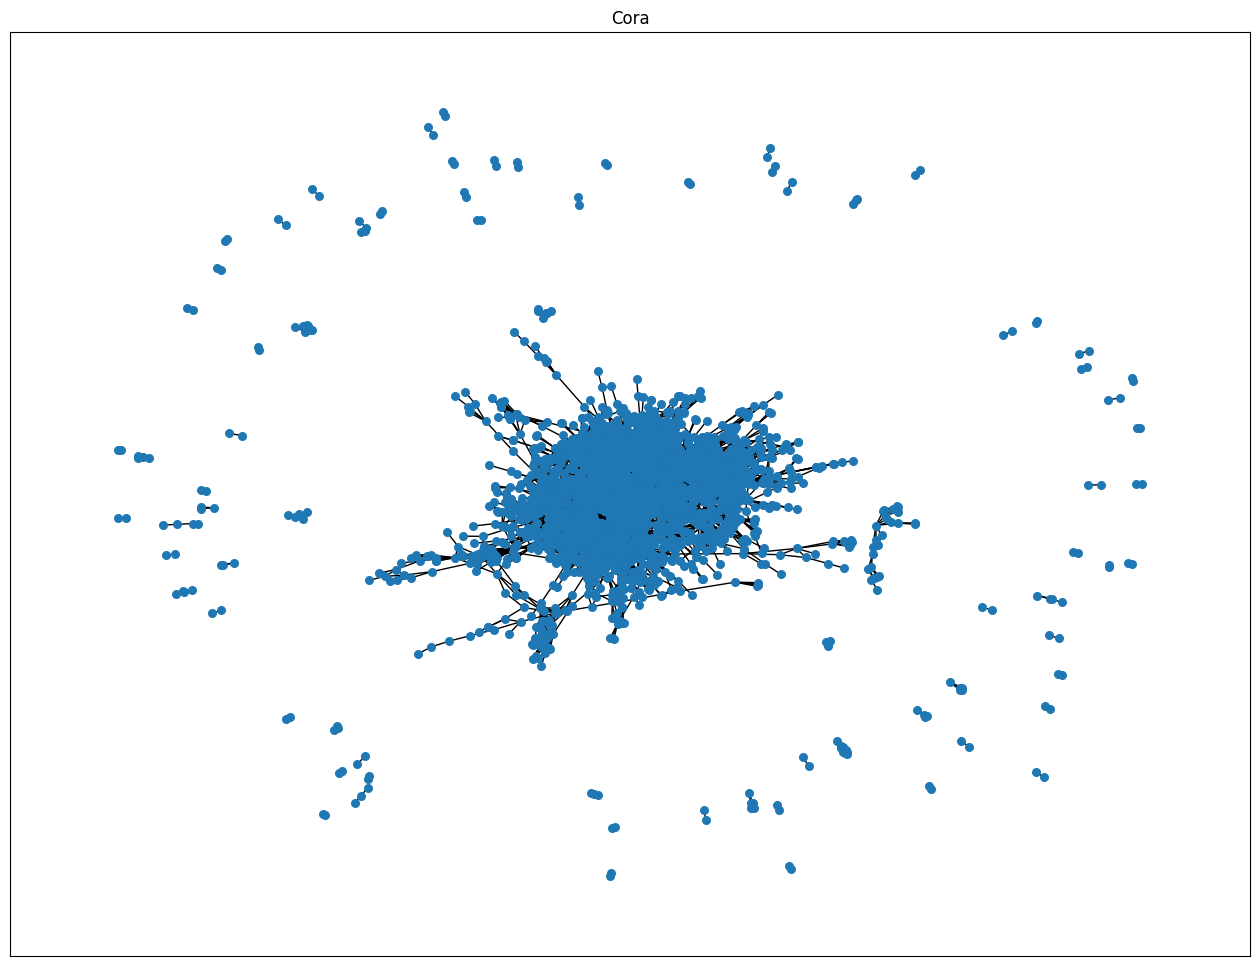

In [3]:
plt.figure(figsize=(16, 12))

G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx(G, with_labels=False, node_size=30)

plt.title('Cora');

### 2.3 Extract the degree values

In [4]:
degrees = dict(nx.degree(G))
node_indices = list(degrees.keys())
node_degrees = list(degrees.values())

max_degree = max(node_degrees)
node_idx = np.argmax(node_degrees).item()

Node 1358 has the largest degree value 168.


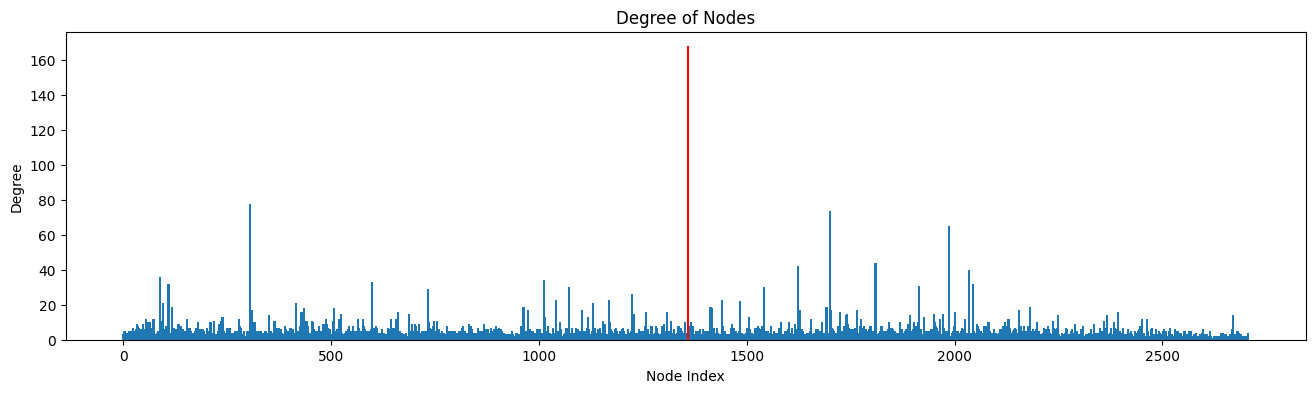

In [5]:
plt.figure(figsize=(16, 4))

plt.bar(node_indices, node_degrees, width=5.0)

plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')

plt.title('Degree of Nodes')
plt.xlabel('Node Index')
plt.ylabel('Degree');

print(f'Node {node_idx} has the largest degree value {max_degree}.')

## 3. Build a GAT model

Note that `GraphLIME` only accepts models that output log probabilities,

so please not to forget to use `F.log_softmax()` function to output the predictions.

### 3.1 Define a GAT class

In [6]:
class GAT(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim,
                 heads_1=8, heads_2=1, att_dropout=0.6, input_dropout=0.6):
        
        super(GAT, self).__init__()

        self.att_dropout = att_dropout
        self.input_dropout = input_dropout

        self.conv1 = GATConv(in_channels=input_dim,
                             out_channels=hidden_dim // heads_1,
                             heads=heads_1,
                             concat=True,
                             dropout=att_dropout)
        self.conv2 = GATConv(in_channels=hidden_dim,
                             out_channels=output_dim,
                             heads=heads_2,
                             concat=False,
                             dropout=att_dropout)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.input_dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.input_dropout, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

### 3.2 Instantiate a GAT model

In [7]:
hparams = {
    'input_dim': data.num_node_features,
    'hidden_dim': 16,
    'output_dim': max(data.y).item() + 1
}

model = GAT(**hparams)
model

GAT(
  (conv1): GATConv(1433, 2, heads=8)
  (conv2): GATConv(16, 7, heads=1)
)

## 4. Train our model!

In [8]:
def accuracy(output, labels):
    _, pred = output.max(dim=1)
    correct = pred.eq(labels).double()
    correct = correct.sum()
    
    return correct / len(labels)

In [9]:
lr = 0.005
epochs = 50

model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    output = model(data.x, data.edge_index)
    loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        acc = accuracy(output[data.train_mask], data.y[data.train_mask])
        print('Epoch: {:3d}, acc = {:.3f}'.format(epoch, acc))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0, acc = 0.193
Epoch:  10, acc = 0.386
Epoch:  20, acc = 0.557
Epoch:  30, acc = 0.557
Epoch:  40, acc = 0.643


## 5. Explain node features!

The node that has the largest degree value

In [10]:
node_idx

1358

In [11]:
model.eval()

GAT(
  (conv1): GATConv(1433, 2, heads=8)
  (conv2): GATConv(16, 7, heads=1)
)

### 5.1 Compute the coefficients  (or $\beta$ values) of features

Parameters of `GraphLIME`:

* `hop`

    `GraphLIME` will extract a subgraph with center at the `node_idx` node, and radius equals to `hop`.


* `rho`

    A regularization parameter that multiplies the $L_1$ term. The larger the value is, the sparser the $\beta_i$ values are.
    

* `cached`

    If set to `True`, the `GraphLIME` object will cache the computation of log probabilities on the first execution, and will use the cached version for further explanation. It will speed up when explaining other nodes in the same graph.

In [12]:
# instantiate a GraphLIME object
explainer = GraphLIME(model, hop=2, rho=0.05, cached=True)

In [13]:
# explain node features by calling the method `explain_node()`
coefs = explainer.explain_node(node_idx, data.x, data.edge_index)

coefs

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

### 5.2 Visualize the coefficients ($\beta$ values)

The 1263-th feature is the most important.


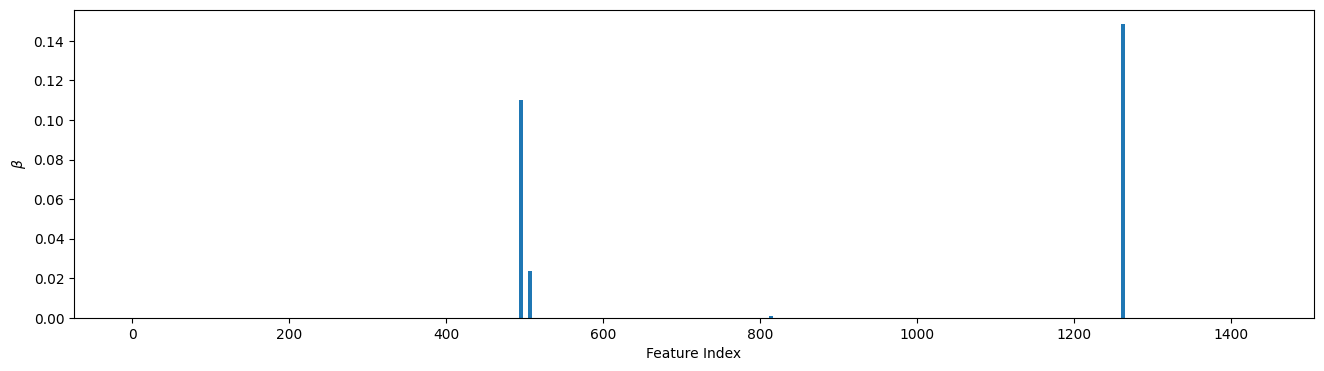

In [14]:
plt.figure(figsize=(16, 4))

x = list(range(data.num_node_features))

plt.bar(x, coefs, width=5.0)
plt.xlabel('Feature Index')
plt.ylabel(r'$\beta$');

print(f'The {np.argmax(coefs)}-th feature is the most important.')

In [15]:
from other_explainers import LIME


In [16]:
 explainer = LIME(model, 50)

In [17]:
coefs =  explainer.explain_node(node_idx, data.x, data.edge_index)

The 429-th feature is the most important.


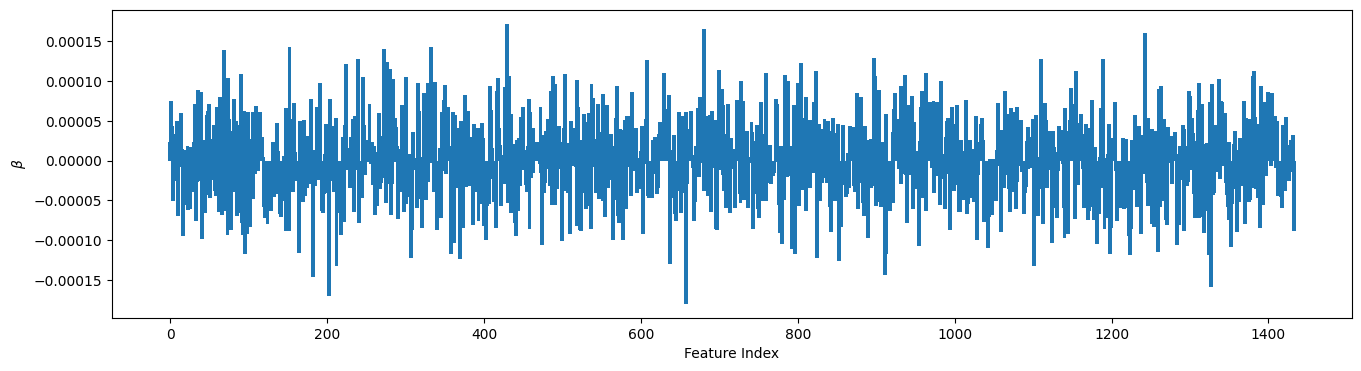

In [18]:
plt.figure(figsize=(16, 4))

x = list(range(data.num_node_features))

plt.bar(x, coefs, width=5.0)
plt.xlabel('Feature Index')
plt.ylabel(r'$\beta$');

print(f'The {np.argmax(coefs)}-th feature is the most important.')
plt.savefig('results/limitation on graph data.png', dpi=300, bbox_inches='tight') 